<a href="https://colab.research.google.com/github/carlosmatherson/PolymerGCN/blob/main/TgGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


Install Spektral and RDKit.

In [ ]:
!pip install spektral
!pip install rdkit

Import necessary packages and functions.

In [218]:
# general tools
import numpy as np
import pandas as pd

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Spektral
from spektral.utils.sparse import reorder
from spektral.data.graph import Graph
from spektral.data import Dataset, BatchLoader
from spektral.layers import GCNConv, GlobalSumPool

# SciKit-Learn
from sklearn.model_selection import KFold

# TensorFlow & Keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

# Matplotlib
import matplotlib.pyplot as plt

# Featurization

Onehot Encoding: Maps input elements x which are not in the permitted list to the last element of the permitted list.

In [177]:
# Onehot Encoding
def one_hot_encoding(x, permitted_list):

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

Atom Featurization: Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.

In [178]:
# Atom Featurization
def get_atom_features(atom):

    # define list of permitted atoms
    permitted_list_of_atoms = ['Br', 'C', 'Cl', 'F', 'Li', 'N', 'O', 'P', 'S', 'Si', '*']
    
    # compute atom features
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
    implicit_valence_enc = one_hot_encoding(str(atom.GetImplicitValence()), [0, 1, 2, 3, 4, "MoreThanFour"])
    degree_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    aromaticity_enc = [int(atom.GetIsAromatic())]

    atom_feature_vector = atom_type_enc + n_hydrogens_enc + implicit_valence_enc + degree_enc + aromaticity_enc

    return np.array(atom_feature_vector)

Bond Featurization: Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.

In [179]:
# Bond Featurisation
def get_bond_features(bond, use_stereochemistry = True):

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

Dablander, Markus. How to Turn a SMILES String into a Molecular Graph for Pytorch Geometric | Oxford Protein Informatics Group. https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/. Accessed 11 July 2022.


# Create Dataset

Subclass the Dataset class to standardize how graph datasets are represented in Spektral. Here, you can choose the endpoint to work with.

In [188]:
class MyDataset(Dataset):
  def read(self):
    global polydata
    polydata = pd.read_csv("https://raw.githubusercontent.com/carlosmatherson/PolymerGCN/main/SMILESwithAllProps.csv") #"Tg"
    #polydata = pd.read_csv("https://raw.githubusercontent.com/liugangcode/GREA/main/data/tg_prop/raw/tg_raw.csv") # "tg"
    graph_list = makeGraphObjList(polydata["SMILES"], polydata["Tg"]) 
    return graph_list

Define `makeGraphObjList` to create Spektral graph dataset from smiles and labels. The function takes a list of SMILES strings `x_smiles = [smiles_1, smiles_2, ....]` and a list of numerial labels for the SMILES strings `y = [y_1, y_2, ...]` as inputs. The output is a list of spektral.data.graph.Graph objects that can readily be used for machine learning, `graph_list = [G_1, G_2, ...]`. 






In [189]:
def makeGraphObjList(x_smiles, y):
    
    graph_list = []

    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)
        
        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct adjacency matrix (n_nodes, n_nodes), full matrix
        A = np.array(GetAdjacencyMatrix(mol)) # full matrix

        # construct edge index array Ei of shape (n_edges, 2), sparse matrix
        Ei = np.transpose(np.nonzero(A)) # vertical format
        (rows, cols) = np.transpose(Ei)

        # construct node feature matrix Xn of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))
        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
        
        # construct edge feature array Ef of shape (n_edges, n_edge_features)
        E = np.zeros((n_edges, n_edge_features))
        # for (k, (i,j)) in enumerate(zip(rows, cols)):
        #     E[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        # reorder(Ei, E)
        
        # construct label tensor
        Y = np.array([y_val])

        # construct Spektral graph object and append to dataset (list)
        graph_list.append(Graph(x=X, a=A, e=E, y=Y))
        
    return graph_list 

Load data.

In [210]:
data = MyDataset()  # store data in data
#gradient = polydata["Tg"]

# Graph Convolutional Network

Defining R-squared function not available through Keras

In [227]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

Hyperparameters

In [228]:
learning_rate = 1e-3                # Learning rate
epochs = 2 #4000                    # Number of training epochs, 4000
batch_size = 15                     # Batch size 
train_split = 0.8                   # split %
num_folds = 5
optimizer = Adam(learning_rate)     # Optimizer
metrics = [RootMeanSquaredError(), coeff_determination]  # metric
validation_steps = 5                # Validation steps
l2 = regularizers.L2(1e-2)
loss = 'mse'                        # Loss function

GCN body: 6 layers, 100 nodes each, global pooling, no masking

NN body: 2 layers, 300 nodes each, output layer

In [225]:
#model
class myGCN(Model):

    def __init__(self):
      super().__init__()
      # GCN+LR
      self.conv1 = GCNConv(100, activation="relu", kernel_regularizer=l2)  # 6 convolutional layers
      self.conv2 = GCNConv(100, activation="relu", kernel_regularizer=l2)  # 100 nodes per
      self.conv3 = GCNConv(100, activation="relu", kernel_regularizer=l2)  # inputs are zero-padded
      self.conv4 = GCNConv(100, activation="relu", kernel_regularizer=l2)
      self.conv5 = GCNConv(100, activation="relu", kernel_regularizer=l2)
      self.conv6 = GCNConv(100, activation="relu", kernel_regularizer=l2)  
      self.global_pool = GlobalSumPool()                                   # "graph embedding"
      self.dense1 = Dense(data.n_labels, kernel_regularizer=l2)            # GCN lin. regression out
      # GCN+NN
      self.mlp1 = Dense(units=300, activation="relu", kernel_regularizer=l2) # 2 hidden layers
      self.mlp2 = Dense(units=300, activation="relu", kernel_regularizer=l2) # 300 nodes per
      self.dense2 = Dense(data.n_labels, kernel_regularizer=l2)              # output       

    def call(self, inputs):
      global embed, gcn_out, nn_out
      x, a = inputs[0], inputs[1]
      x = self.conv1([x, a])
      x = self.conv2([x, a])
      x = self.conv3([x, a])
      x = self.conv4([x, a])
      x = self.conv5([x, a])
      x = self.conv6([x, a])
      embed = x = self.global_pool(x)
      gcn_out = self.dense1(x)
      x = self.mlp1(x)
      x = self.mlp2(x)
      nn_out = self.dense2(x)

      return gcn_out, nn_out # return loss and metric for GCN and NN layers

model = myGCN()
model.compile(optimizer=optimizer, metrics=metrics, loss=loss, run_eagerly=True)

Load testing data as batch (zero-padded with masking) and evaluate the model

Load training data as batch (zero-padded with masking) and train the model

In [238]:
k = KFold(n_splits=num_folds, random_state=None, shuffle=True)
loss = []

i=0
for train_index, test_index in k.split(data):
  #print("TRAIN:", train_index, "TEST:", test_index)
  dataset_tr = data[train_index]
  dataset_te = data[test_index]
  
  loader_tr = BatchLoader(dataset_tr, batch_size=batch_size, mask=True, shuffle=True)
  loader_te = BatchLoader(dataset_te, batch_size=batch_size, mask=True)
  
  results = model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, epochs=epochs)

  # results = model.fit(
  #                 loader_tr.load(),
  #                 steps_per_epoch=loader_tr.steps_per_epoch,
  #                 epochs=epochs,
  #                 validation_data=loader_te.load(),
  #                 validation_steps=5,
  # )

  print("Testing model")
  loss.append(model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch))

  print("\n\nDone. Test loss: \tMSE \t\t  GCN MSE \t NN MSE \t GCN RMSE \t\t NN RMSE \n \t\t{}".format(loss[i]))
  print("\n")
  i+=1

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
/usr/local/lib/python3.7/dist-packages/spektral/layers/convolutional/conv.py:94: UserWarning: The adjacency matrix of dtype <dtype: 'int32'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  f"The adjacency matrix of dtype {a.dtype} is incompatible with the dtype "


24/24 [==============================] - 3s 105ms/step - loss: 3342.1594 - output_1_loss: 1907.0822 - output_2_loss: 1427.6340 - output_1_root_mean_squared_error: 43.6702 - output_1_coeff_determination: 0.7158 - output_2_root_mean_squared_error: 37.7840 - output_2_coeff_determination: 0.7849
Epoch 2/2
24/24 [==============================] - 3s 123ms/step - loss: 3264.5095 - output_1_loss: 1741.0848 - output_2_loss: 1515.9608 - output_1_root_mean_squared_error: 41.7263 - output_1_coeff_determination: 0.7544 - output_2_root_mean_squared_error: 38.9353 - output_2_coeff_determination: 0.7814
Testing model
6/6 [==============================] - 1s 80ms/step - loss: 4963.3125 - output_1_loss: 2678.3779 - output_2_loss: 2277.4600 - output_1_root_mean_squared_error: 51.7530 - output_1_coeff_determination: 0.6965 - output_2_root_mean_squared_error: 47.7227 - output_2_coeff_determination: 0.7228


Done. Test loss: 	MSE 		  GCN MSE 	 NN MSE 	 GCN RMSE 		 NN RMSE 
 		[4963.3125, 2678.3779296875, 

In [264]:
lossDF = pd.DataFrame(loss, columns = ['Tot. MSE','GCN MSE','NN MSE','GCN RMSE','GCN R^2','NN RMSE','NN R^2'])
lossDF.loc['Mean'] = lossDF.mean()
display(lossDF)

,Tot. MSE,GCN MSE,NN MSE,GCN RMSE,GCN R^2,NN RMSE,NN R^2
0,4963.312500,2678.377930,2277.459961,51.753044,0.696490,47.722740,0.722765
1,2869.134033,1653.736694,1207.880127,40.666161,0.776491,34.754570,0.823529
2,3683.843018,1975.962769,1700.308472,44.451801,0.751336,41.234798,0.785128
3,3795.447998,2102.289551,1685.543213,45.850731,0.735342,41.055367,0.787130
4,2855.863770,1439.384888,1408.819458,37.939228,0.803367,37.534245,0.812743
Mean,3633.520264,1969.950366,1656.002246,44.132193,0.752605,40.460344,0.786259


# Visualization (future work)

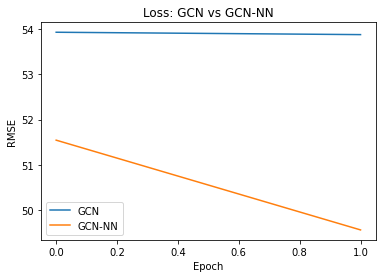

In [233]:
fig, ax = plt.subplots()
plt.plot(results.history['output_1_root_mean_squared_error'], label="GCN")
plt.plot(results.history['output_2_root_mean_squared_error'], label="GCN-NN")
plt.title("Loss: GCN vs GCN-NN")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
ax.legend()
plt.show()

[0.6071281  0.31629074]


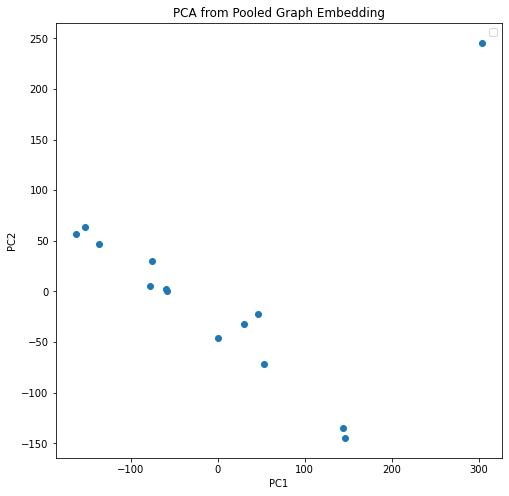

In [234]:
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize

# Create a 2D PCA projection of the embeddings
GCNrepresentation = embed.numpy()
pca = PCA(n_components=2)
pca.fit(GCNrepresentation)
pca_gcn = pca.transform(GCNrepresentation)
print(pca.explained_variance_ratio_)

# Plot those points as a scatter plot 
fig, ax = plt.subplots(figsize=(8,8))
num_categories = data.n_labels
plt.title("PCA from Pooled Graph Embedding")
plt.xlabel("PC1")
plt.ylabel("PC2")
ax.legend()
ax.scatter(pca_gcn[:,0],pca_gcn[:,1]) # c=np.array(cmap(lab)).reshape(1,4)
plt.show()